# With Rope

## For all the runs (concatenate the values)

In [19]:
import pandas as pd
import wandb
import numpy as np

api = wandb.Api()

runs = api.runs(
    path="explainableml/ICL_torch",
    filters={
        "config.normalize_progress_measure": True,
        "config.rope": True,
        "state": "finished"
    }
)
# Extract data and filter based on IC_Accuracy
runs = [
    run for run in runs 
    if run.config.get("K", 0) in [2048,4096,8192,16384]]
# ---- 1. Gather every time-step from every run ---------------------------------
#    For each metric build ONE long Series by concatenating the histories
bags = {
    "IC_Accuracy":        [],
    "IC2_Accuracy":       [],
    "IH_strength_layer1": [],
    "IH_strength_layer2": [],
    "TILA_layer1":        [],
    "TILA_layer2":        [],
    "TIIA_layer1":        [],
    "TIIA_layer2":        [],
    "TLA_layer1":         [],
    "TLA_layer2":         [],
    "prev_1_attn_layer1": [],
    "prev_1_attn_layer2": [],
    "prob_icl_labels":    [],
}

for run in runs:
    h = run.history()                     # one DataFrame per run
    for k in bags:
        # Normalize the vector
        v = (h[k] - np.mean(h[k]).item()) / np.std(h[k]).item()
        bags[k].append(v)              # keep the whole Series (all steps)

# ---- 2. Concatenate into vectors ---------------------------------------------
vectors = {k: pd.concat(v, ignore_index=True) for k, v in bags.items()}

# ---- 3. Correlation matrix (Pearson, by default) -----------------------------
df = pd.DataFrame(vectors) 
corr = df.corr(method="pearson")

# ---- 4. Correlation of every metric with IC_Accuracy -------------------------
corr_with_ic = corr["IC_Accuracy"].sort_values(ascending=False)
corr_with_ic2 = corr["IC2_Accuracy"].sort_values(ascending=False)

print("\nPearson r between each metric vector and IC_Accuracy:")
print(corr_with_ic)
# print("\nPearson r between each metric vector and IC2_Accuracy:")
# print(corr_with_ic2)



Pearson r between each metric vector and IC_Accuracy:
IC_Accuracy           1.000000
IC2_Accuracy          0.974836
prev_1_attn_layer1    0.715670
prob_icl_labels       0.654233
IH_strength_layer2    0.608748
TLA_layer1            0.589275
TILA_layer1           0.557198
TILA_layer2           0.187317
TLA_layer2            0.111833
IH_strength_layer1    0.062432
TIIA_layer2          -0.041004
prev_1_attn_layer2   -0.096823
TIIA_layer1          -0.540919
Name: IC_Accuracy, dtype: float64


In [ ]:
# print the correlation between all the metrics
all_metrics = df.columns
for i in all_metrics:
    print(f"\nPearson r between each metric vector and {i}")
    print(corr[i].sort_values(ascending=False))

In [2]:
len(runs)

12

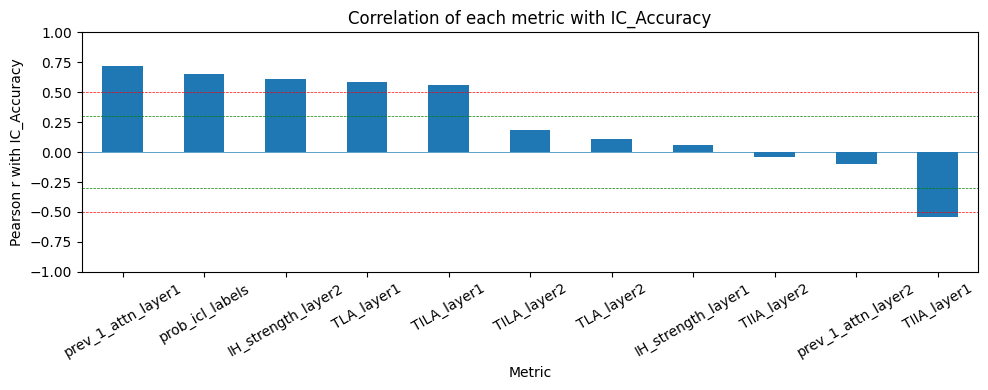

In [3]:
import matplotlib.pyplot as plt

# Assume `corr_with_ic` is a pandas Series whose index = metric names
# and whose values = Pearson r against IC_Accuracy.

fig, ax = plt.subplots(figsize=(10, 4))

corr_with_ic[2:].plot(kind="bar", ax=ax)

ax.set_xlabel("Metric")
ax.set_ylabel("Pearson r with IC_Accuracy")
ax.set_title("Correlation of each metric with IC_Accuracy")
ax.set_ylim(-1, 1)               # full Pearson range
ax.axhline(0, linewidth=0.5)     # horizontal zero line for reference
ax.axhline(0.3, linewidth=0.5, color="green", linestyle="--") # threshold for significance
ax.axhline(-0.3, linewidth=0.5, color="green", linestyle="--") # threshold for significance
ax.axhline(0.5, linewidth=0.5, color="red", linestyle="--") # threshold for significance
ax.axhline(-0.5, linewidth=0.5, color="red", linestyle="--") # threshold for significance
ax.tick_params(axis='x', labelrotation=30)
plt.tight_layout()
plt.show()


### Linear Regression

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score, KFold
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
X = df.drop(columns=["IC_Accuracy", "IC2_Accuracy"])
y = df["IC_Accuracy"]     
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# X_scaled = X
lin = LinearRegression()
cv   = KFold(n_splits=5, shuffle=True, random_state=0)
# Coefficient of determination (R²) averaged across folds
metrics = ["neg_mean_squared_error", "neg_mean_absolute_error","r2","neg_root_mean_squared_error"]
for metric in metrics:
    r2_lin = cross_val_score(lin, X_scaled, y, cv=cv, scoring=metric)
    print(f"Linear {metric}  (mean±sd): {r2_lin.mean():.3f} ± {r2_lin.std():.3f}")
    ridge = RidgeCV(cv=cv)
    r2_ridge = cross_val_score(ridge, X_scaled, y, cv=cv, scoring=metric)
    print(f"Ridge {metric}  (mean±sd): {r2_ridge.mean():.3f} ± {r2_ridge.std():.3f}")
    lasso = LassoCV(cv=cv, random_state=0, max_iter=10000)
    r2_lasso = cross_val_score(lasso, X_scaled, y, cv=cv, scoring=metric)
    print(f"Lasso {metric}  (mean±sd): {r2_lasso.mean():.3f} ± {r2_lasso.std():.3f}")

Linear neg_mean_squared_error  (mean±sd): -0.222 ± 0.029
Ridge neg_mean_squared_error  (mean±sd): -0.222 ± 0.029
Lasso neg_mean_squared_error  (mean±sd): -0.222 ± 0.030
Linear neg_mean_absolute_error  (mean±sd): -0.294 ± 0.011
Ridge neg_mean_absolute_error  (mean±sd): -0.294 ± 0.011
Lasso neg_mean_absolute_error  (mean±sd): -0.293 ± 0.011
Linear r2  (mean±sd): 0.778 ± 0.021
Ridge r2  (mean±sd): 0.778 ± 0.021
Lasso r2  (mean±sd): 0.778 ± 0.022
Linear neg_root_mean_squared_error  (mean±sd): -0.470 ± 0.030
Ridge neg_root_mean_squared_error  (mean±sd): -0.470 ± 0.030
Lasso neg_root_mean_squared_error  (mean±sd): -0.470 ± 0.031


In [12]:
model = [lin, ridge, lasso]
for m in model:
    m.fit(X_scaled, y)
    coefs = m.coef_
    feature_names = X.columns

    import pandas as pd
    coef_df = pd.DataFrame({
        "feature": feature_names,
        "coefficient": coefs,
    }).sort_values("coefficient", ascending=False)

    print(m.__class__.__name__)
    print(coef_df)

LinearRegression
               feature  coefficient
6           TLA_layer1     1.170908
4          TIIA_layer1     1.071238
10     prob_icl_labels     0.416280
7           TLA_layer2     0.368766
8   prev_1_attn_layer1     0.368745
5          TIIA_layer2     0.357713
1   IH_strength_layer2     0.203519
9   prev_1_attn_layer2     0.077994
3          TILA_layer2     0.057261
0   IH_strength_layer1    -0.022892
2          TILA_layer1    -0.030086
RidgeCV
               feature  coefficient
6           TLA_layer1     1.034454
4          TIIA_layer1     0.976929
10     prob_icl_labels     0.418147
7           TLA_layer2     0.375659
8   prev_1_attn_layer1     0.374979
5          TIIA_layer2     0.357158
1   IH_strength_layer2     0.204028
9   prev_1_attn_layer2     0.075633
3          TILA_layer2     0.057674
2          TILA_layer1     0.008519
0   IH_strength_layer1    -0.023037
LassoCV
               feature  coefficient
6           TLA_layer1     0.917751
4          TIIA_layer1     0.85

In [13]:
r_pair = df["prev_1_attn_layer1"].corr(df["IH_strength_layer2"])
print(f"Pearson r(prev_1_attn_layer1 , IH_strength_layer2) = {r_pair:.3f}")


Pearson r(prev_1_attn_layer1 , IH_strength_layer2) = 0.473


In [23]:
from itertools import combinations
from sklearn.model_selection import cross_val_score
import numpy as np

def best_feature_subset(X, y, model, cv, scoring="r2"):
    n_features = X.shape[1]
    best_score = -np.inf
    best_subset = None

    for k in range(1, n_features + 1):  # try all subset sizes
        for subset in combinations(range(n_features), k):
            X_sub = X[:, subset]
            score = cross_val_score(model, X_sub, y, cv=cv, scoring=scoring).mean()
            if score > best_score:
                best_score = score
                best_subset = subset
    return best_subset, best_score

# Usage
lin = LinearRegression()
best_cols, best_r2 = best_feature_subset(X_scaled, y, lin, cv)
print(f"Best R²: {best_r2:.3f} using columns: {best_cols}")


Best R²: 0.791 using columns: (0, 1, 2, 3, 4, 5, 6, 7, 8, 10)


### Random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(
        n_estimators=500,
        max_depth=None,
        n_jobs=-1,
        random_state=0)

r2_rf = cross_val_score(rf, X, y, cv=cv, scoring="r2")
print(f"RF R²      (mean±sd): {r2_rf.mean():.3f} ± {r2_rf.std():.3f}")

# Interpreting the model
rf.fit(X_scaled, y)

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame to display feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print(feature_importances)

RF R²      (mean±sd): 0.974 ± 0.014
               Feature  Importance
8   prev_1_attn_layer1    0.406958
10     prob_icl_labels    0.303522
1   IH_strength_layer2    0.130136
3          TILA_layer2    0.120085
7           TLA_layer2    0.013329
2          TILA_layer1    0.008568
0   IH_strength_layer1    0.004198
5          TIIA_layer2    0.003965
4          TIIA_layer1    0.003527
6           TLA_layer1    0.003295
9   prev_1_attn_layer2    0.002416


#### Only take 4 measures

In [ ]:
from sklearn.ensemble import RandomForestRegressor
X_filtered = df[["IH_strength_layer2","prev_1_attn_layer1","prob_icl_labels","TILA_layer2"]]
rf = RandomForestRegressor(
        n_estimators=500,
        max_depth=None,
        n_jobs=-1,
        random_state=0)

r2_rf = cross_val_score(rf, X_filtered, y, cv=cv, scoring="r2")
print(f"RF R²      (mean±sd): {r2_rf.mean():.3f} ± {r2_rf.std():.3f}")

# # Interpreting the model
# rf.fit(X_filtered, y)

# # Get feature importances
# importances = rf.feature_importances_

# # Create a DataFrame to display feature importances
# feature_importances = pd.DataFrame({
#     'Feature': X_filtered.columns,
#     'Importance': importances
# }).sort_values('Importance', ascending=False)

# print(feature_importances)

RF R²      (mean±sd): 0.865 ± 0.051


## For ICL runs (concatenate the values)

In [1]:
import pandas as pd
import wandb
import numpy as np
api = wandb.Api()
runs = api.runs(
    path="explainableml/ICL_torch",
    filters={
        "config.normalize_progress_measure": True,
        "config.rope": True,
        "state": "finished"
    }
)

# Extract data and filter based on IC_Accuracy
runs = [
    run for run in runs 
    if run.summary.get("IC_Accuracy", 0) > 0.9]

# ---- 1. Gather every time-step from every run ---------------------------------
#    For each metric build ONE long Series by concatenating the histories
bags = {
    "IC_Accuracy":        [],
    "IC2_Accuracy":       [],
    "IH_strength_layer1": [],
    "IH_strength_layer2": [],
    "TILA_layer1":        [],
    "TILA_layer2":        [],
    "TIIA_layer1":        [],
    "TIIA_layer2":        [],
    "TLA_layer1":         [],
    "TLA_layer2":         [],
    "prev_1_attn_layer1": [],
    "prev_1_attn_layer2": [],
    "prob_icl_labels":    [],
}

for run in runs:
    h = run.history()                     # one DataFrame per run
    for k in bags:
        v = (h[k] - np.mean(h[k]).item()) / np.std(h[k]).item()
        bags[k].append(v)    

# ---- 2. Concatenate into vectors ---------------------------------------------
vectors = {k: pd.concat(v, ignore_index=True) for k, v in bags.items()}

# ---- 3. Correlation matrix (Pearson, by default) -----------------------------
df = pd.DataFrame(vectors)                # rows = all time-steps from all runs
corr = df.corr(method="pearson")

# ---- 4. Correlation of every metric with IC_Accuracy -------------------------
corr_with_ic = corr["IC_Accuracy"].sort_values(ascending=False)
corr_with_ic2 = corr["IC2_Accuracy"].sort_values(ascending=False)

print("\nPearson r between each metric vector and IC_Accuracy:")
print(corr_with_ic)
# print("\nPearson r between each metric vector and IC2_Accuracy:")
# print(corr_with_ic2)



Pearson r between each metric vector and IC_Accuracy:
IC_Accuracy           1.000000
IC2_Accuracy          0.998271
TILA_layer2           0.966012
IH_strength_layer2    0.961320
TLA_layer2            0.949460
prev_1_attn_layer1    0.679023
prev_1_attn_layer2    0.459299
prob_icl_labels       0.334088
TLA_layer1            0.282051
TILA_layer1           0.223524
IH_strength_layer1   -0.132018
TIIA_layer1          -0.219126
TIIA_layer2          -0.789352
Name: IC_Accuracy, dtype: float64


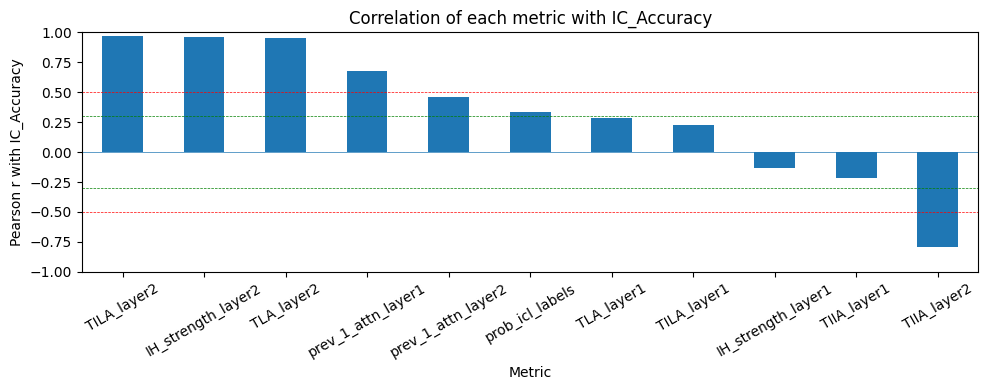

In [2]:
import matplotlib.pyplot as plt

# Assume `corr_with_ic` is a pandas Series whose index = metric names
# and whose values = Pearson r against IC_Accuracy.

fig, ax = plt.subplots(figsize=(10, 4))

corr_with_ic[2:].plot(kind="bar", ax=ax)

ax.set_xlabel("Metric")
ax.set_ylabel("Pearson r with IC_Accuracy")
ax.set_title("Correlation of each metric with IC_Accuracy")
ax.set_ylim(-1, 1)               # full Pearson range
ax.axhline(0, linewidth=0.5)     # horizontal zero line for reference
ax.axhline(0.3, linewidth=0.5, color="green", linestyle="--") # threshold for significance
ax.axhline(-0.3, linewidth=0.5, color="green", linestyle="--") # threshold for significance
ax.axhline(0.5, linewidth=0.5, color="red", linestyle="--") # threshold for significance
ax.axhline(-0.5, linewidth=0.5, color="red", linestyle="--") # threshold for significance
ax.tick_params(axis='x', labelrotation=30)
plt.tight_layout()
plt.show()


### Linear Regression

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score, KFold
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
X = df.drop(columns=["IC_Accuracy", "IC2_Accuracy"])
y = df["IC_Accuracy"]     
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# X_scaled = X
lin = LinearRegression()
cv   = KFold(n_splits=5, shuffle=True, random_state=0)
# Coefficient of determination (R²) averaged across folds
r2_lin = cross_val_score(lin, X_scaled, y, cv=cv, scoring="r2")
print(f"Linear R²  (mean±sd): {r2_lin.mean():.3f} ± {r2_lin.std():.3f}")
ridge = RidgeCV(cv=cv)
r2_ridge = cross_val_score(ridge, X_scaled, y, cv=cv, scoring="r2")
print(f"Ridge R²  (mean±sd): {r2_ridge.mean():.3f} ± {r2_ridge.std():.3f}")
lasso = LassoCV(cv=cv, random_state=0)
r2_lasso = cross_val_score(lasso, X_scaled, y, cv=cv, scoring="r2")
print(f"Lasso R²  (mean±sd): {r2_lasso.mean():.3f} ± {r2_lasso.std():.3f}")

Linear R²  (mean±sd): 0.973 ± 0.002
Ridge R²  (mean±sd): 0.973 ± 0.002
Lasso R²  (mean±sd): 0.970 ± 0.002


In [10]:
lin.fit(X_scaled, y)
coefs = lin.coef_
feature_names = X.columns

import pandas as pd
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs,
    "abs_coeff": abs(coefs)
}).sort_values("abs_coeff", ascending=False)

print(coef_df)

               feature  coefficient  abs_coeff
1   IH_strength_layer2     2.898874   2.898874
3          TILA_layer2    -2.710379   2.710379
6           TLA_layer1     0.769210   0.769210
7           TLA_layer2     0.669905   0.669905
4          TIIA_layer1     0.321745   0.321745
2          TILA_layer1    -0.299658   0.299658
9   prev_1_attn_layer2     0.109561   0.109561
10     prob_icl_labels     0.083522   0.083522
0   IH_strength_layer1     0.049730   0.049730
8   prev_1_attn_layer1     0.023955   0.023955
5          TIIA_layer2    -0.000280   0.000280


### Random Forest

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
import pandas as pd

X = df.drop(columns=["IC_Accuracy", "IC2_Accuracy"])
y = df["IC_Accuracy"]   
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
cv   = KFold(n_splits=5, shuffle=True, random_state=0)
rf = RandomForestRegressor(
        n_estimators=500,
        max_depth=None,
        n_jobs=-1,
        random_state=0)

r2_rf = cross_val_score(rf, X_scaled, y, cv=cv, scoring="r2")
print(f"RF R²      (mean±sd): {r2_rf.mean():.3f} ± {r2_rf.std():.3f}")

# Interpreting the model
rf.fit(X_scaled, y)

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame to display feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print(feature_importances)

RF R²      (mean±sd): 0.998 ± 0.001
               Feature  Importance
1   IH_strength_layer2    0.961592
10     prob_icl_labels    0.016051
3          TILA_layer2    0.010938
8   prev_1_attn_layer1    0.003424
2          TILA_layer1    0.001928
0   IH_strength_layer1    0.001607
4          TIIA_layer1    0.001252
7           TLA_layer2    0.001213
5          TIIA_layer2    0.000885
6           TLA_layer1    0.000684
9   prev_1_attn_layer2    0.000426


## No ICL

In [11]:
import pandas as pd
import wandb

api = wandb.Api()
# Filter for runs that have the an IC-Accuracy > 0.5
runs = api.runs(
    path="explainableml/ICL_torch",
    filters={
        "config.normalize_progress_measure": True,
        "config.rope": True,
        "state": "finished"
    }
)

# Extract data and filter based on IC_Accuracy
runs = [
    run for run in runs 
    if run.summary.get("IC_Accuracy", 0) < 0.5
]

# ---- 1. Gather every time-step from every run ---------------------------------
#    For each metric build ONE long Series by concatenating the histories
bags = {
    "IC_Accuracy":        [],
    "IC2_Accuracy":       [],
    "IH_strength_layer1": [],
    "IH_strength_layer2": [],
    "TILA_layer1":        [],
    "TILA_layer2":        [],
    "TIIA_layer1":        [],
    "TIIA_layer2":        [],
    "TLA_layer1":         [],
    "TLA_layer2":         [],
    "prev_1_attn_layer1": [],
    "prev_1_attn_layer2": [],
    "prob_icl_labels":    [],
}

for run in runs:
    h = run.history()                     # one DataFrame per run
    for k in bags:
        v = (h[k] - np.mean(h[k]).item()) / np.std(h[k]).item()
        bags[k].append(v)    

# ---- 2. Concatenate into vectors ---------------------------------------------
vectors = {k: pd.concat(v, ignore_index=True) for k, v in bags.items()}

# ---- 3. Correlation matrix (Pearson, by default) -----------------------------
df = pd.DataFrame(vectors)                # rows = all time-steps from all runs
corr = df.corr(method="pearson")

# ---- 4. Correlation of every metric with IC_Accuracy -------------------------
corr_with_ic = corr["IC_Accuracy"].sort_values(ascending=False)
corr_with_ic2 = corr["IC2_Accuracy"].sort_values(ascending=False)

print("\nPearson r between each metric vector and IC_Accuracy:")
print(corr_with_ic)
# print("\nPearson r between each metric vector and IC2_Accuracy:")
# print(corr_with_ic2)



Pearson r between each metric vector and IC_Accuracy:
IC_Accuracy           1.000000
prob_icl_labels       0.954121
IC2_Accuracy          0.937104
TLA_layer1            0.886864
TILA_layer1           0.876373
prev_1_attn_layer1    0.672870
TIIA_layer2           0.564304
IH_strength_layer2    0.327688
IH_strength_layer1   -0.312846
TILA_layer2          -0.551687
prev_1_attn_layer2   -0.595008
TLA_layer2           -0.613405
TIIA_layer1          -0.885864
Name: IC_Accuracy, dtype: float64


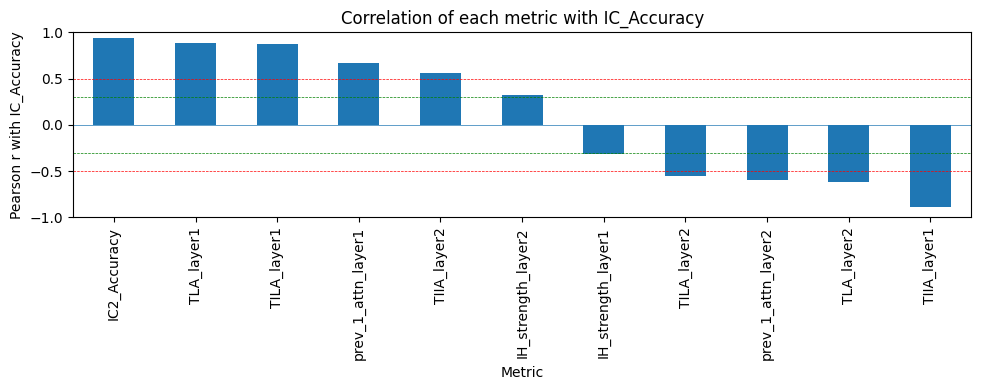

In [12]:
import matplotlib.pyplot as plt

# Assume `corr_with_ic` is a pandas Series whose index = metric names
# and whose values = Pearson r against IC_Accuracy.

fig, ax = plt.subplots(figsize=(10, 4))

corr_with_ic[2:].plot(kind="bar", ax=ax)

ax.set_xlabel("Metric")
ax.set_ylabel("Pearson r with IC_Accuracy")
ax.set_title("Correlation of each metric with IC_Accuracy")
ax.set_ylim(-1, 1)               # full Pearson range
ax.axhline(0, linewidth=0.5)     # horizontal zero line for reference
ax.axhline(0.3, linewidth=0.5, color="green", linestyle="--") # threshold for significance
ax.axhline(-0.3, linewidth=0.5, color="green", linestyle="--") # threshold for significance
ax.axhline(0.5, linewidth=0.5, color="red", linestyle="--") # threshold for significance
ax.axhline(-0.5, linewidth=0.5, color="red", linestyle="--") # threshold for significance
plt.tight_layout()
plt.show()
